In [2]:
import os
# Set JAX to use CPU only
os.environ["JAX_PLATFORM_NAME"] = "cpu"

import jax
import numpy as np
import jax.numpy as jnp
from tqdm import tqdm
from models.sde_models.utils_for_d4rl_mujoco import get_dataset
import matplotlib.pyplot as plt
import gym
import d4rl
import pickle

import math

No module named 'flow'
No module named 'carla'
pybullet build time: May 20 2022 19:44:17


In [1]:
env_name = "halfcheetah"
dataset_name = "random-v2"
jax_seed = 10
infer_batch_size = 1000
sde_model_list = {
    'halfcheetah-random-v2': ["hc_rand_v2_dsc0.1_simple5_hr-1_dt-0.05_sde.pkl"]
}

In [3]:

if env_name == "hopper":
    from models.sde_models.hopper_sde import load_learned_diffusion
elif env_name == "halfcheetah":
    from models.sde_models.halfcheetah_sde import load_learned_diffusion
elif env_name == "walker2d":
    from models.sde_models.walker2d_sde import load_learned_diffusion
else:
    raise NotImplementedError

device = jax.devices('gpu')[0]
env = gym.make(env_name + "-" + dataset_name)
_rng = jax.random.PRNGKey(jax_seed)
_x0 = np.tile([env.reset()], (infer_batch_size,1))
_u0 = np.zeros((infer_batch_size, env.action_space.shape[0]), dtype=np.float32)
print(_x0.shape, _u0.shape)
my_sde_diffusion = load_learned_diffusion(sde_model_list[env_name + "-" + dataset_name][0])
# Define the diffusion function
def _my_diff_fn(x, u, _rng):
    """ Return the predicted next state
    """
    assert len(x.shape) == len(u.shape) == 2
    # next_rng, _rng = jax.random.split(_rng, 2)
    # _rng = jax.random.split(_rng, x.shape[0])
    diff = jax.vmap(my_sde_diffusion)(x, u)
    return diff, _rng
_diffusion = jax.jit(_my_diff_fn, device=device)
def augmented_diff_fn(x, u , rng):
    batch_x = x.shape[0]
    last_x = x[-1]
    last_u = u[-1]
    if batch_x < infer_batch_size:
        last_x = np.repeat(last_x[None], infer_batch_size-batch_x, axis=0)
        last_u = np.repeat(last_u[None], infer_batch_size-batch_x, axis=0)
        x = np.concatenate((x, last_x), axis=0)
        u = np.concatenate((u, last_u), axis=0)
    diff, next_rng = _diffusion(x, u, rng)
    if batch_x < infer_batch_size:
        diff = diff[:batch_x,:]
    return np.array(diff), next_rng
diffusion_fn = augmented_diff_fn

/home/franckdjeumou/.local/lib/python3.8/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


(1000, 17) (1000, 6)


In [4]:
dataset = get_dataset(env_name + "-" + dataset_name)
diffs = None
number_of_samples = dataset['observations'].shape[0]
next_rng = _rng
for i in tqdm(range(math.ceil(number_of_samples//infer_batch_size))):
    obs_batch = dataset['observations'][i*infer_batch_size:(i+1)*infer_batch_size]
    act_batch = dataset['actions'][i*infer_batch_size:(i+1)*infer_batch_size]
    batch_size = obs_batch.shape[0]
    if batch_size != infer_batch_size:
        obs_batch = np.concatenate([obs_batch, np.zeros((infer_batch_size - batch_size, obs_batch.shape[1]))], axis=0)
        act_batch = np.concatenate([act_batch, np.zeros((infer_batch_size - batch_size, act_batch.shape[1]))], axis=0)
    pred_diff, next_rng = diffusion_fn(dataset['observations'][i*infer_batch_size:(i+1)*infer_batch_size], 
                                      dataset['actions'][i*infer_batch_size:(i+1)*infer_batch_size],
                                      next_rng)
    if diffs is None:
        diffs = pred_diff
    else:
        diffs = np.concatenate((diffs, pred_diff), axis=0)

diffs = np.array(diffs)
# diffs_sum = np.sum(diffs, axis=-1)
diffs_sum = np.mean(diffs, axis=-1)
with open(os.path.join("models", "sde_models", "learned_sde_models", f"{sde_model_list[env_name + '-' + dataset_name][0][:-4]}_diffsum.pkl"), "wb") as f:
    pickle.dump(diffs_sum, f)

100%|██████████| 1000/1000 [00:04<00:00, 227.59it/s]


In [ ]:
# %matplotlib inline
# fig, ax = plt.subplots()
# plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

# # Plot Histogram on x
# plt.hist(diffs_sum, bins=100, density=True, alpha=0.6, color='g')
# plt.yscale('log', nonpositive='clip')
# plt.gca().set(title='Frequency Histogram', ylabel='Frequency')
# # plt.savefig(os.path.join("models", "sde_models", "learned_sde_models", f"{sde_model_list[env_name + '-' + dataset_name][0][:-4]}_diffsum_hist.png"))

In [5]:
%matplotlib widget
import matplotlib.pyplot as plt

# Import seaborn
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')

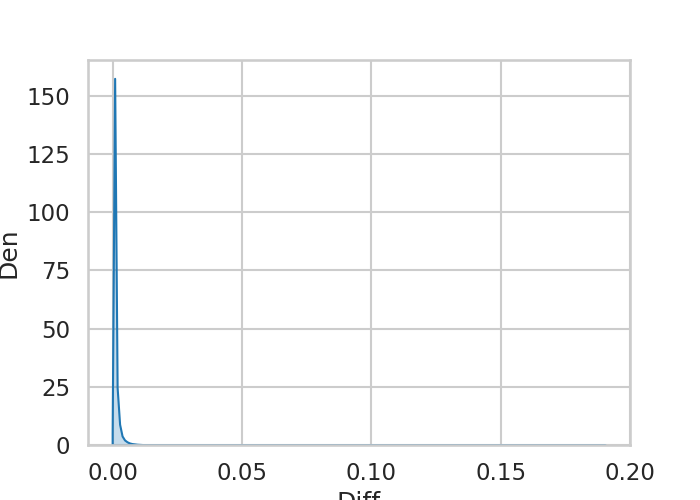

In [6]:
# Do a kde plot of diffs_sum with log on the y axis
fig, ax = plt.subplots(figsize=(7,5))
sns.kdeplot(diffs_sum, log_scale=False, fill=True, ax=ax)
ax.set(xlabel="Diff", ylabel="Den")
ax.grid(True)
